In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/10

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/10


In [0]:
import pandas as pd
import numpy as np
import string

In [0]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])
# 구분다의 default는 \t임. sep='\t'

In [0]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [0]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [0]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [0]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [0]:
lines.shape

(50000, 2)

In [0]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [0]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
filter_eng_words('he is extremely good')

'he is unk good '

In [0]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [0]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [0]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [0]:
len(all_eng_words)

385

In [0]:
len(target_words)

358

In [0]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [0]:
num_decoder_tokens

358

In [0]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [0]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [0]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [0]:
print(eng_max_length)
print(fr_max_length)

8
17


In [0]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [0]:
decoder_target_data.shape

(50000, 17, 359)

In [0]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [0]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [0]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [0]:
# 1. overfitting 줄이기 

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
from tensorflow.keras.regularizers import l1,l2
model1 = Sequential()
model1.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length))
model1.add(Bidirectional(LSTM(1024)))
model1.add(RepeatVector(fr_max_length))
model1.add((LSTM(1024, return_sequences=True)))
model1.add(Dropout(0.9))
model1.add((Dense(len(target_token_index)+1, activation='softmax')))
model1.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 8, 128)            49408     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2048)              9445376   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 17, 2048)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 17, 1024)          12587008  
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 1024)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 17, 359)           367975    
Total params: 22,449,767
Trainable params: 22,449,767
Non-trainable params: 0
__________________________________________

In [0]:
from tensorflow.keras.optimizers import Adam
model1.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy',metrics=['acc'])

In [0]:
history = model1.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
313/313 [==============================] - 17s 54ms/step - loss: 1.1261 - acc: 0.7987 - val_loss: 1.2151 - val_acc: 0.7692
Epoch 2/10
313/313 [==============================] - 16s 51ms/step - loss: 0.9131 - acc: 0.8226 - val_loss: 1.0762 - val_acc: 0.7842
Epoch 3/10
313/313 [==============================] - 16s 51ms/step - loss: 0.8110 - acc: 0.8362 - val_loss: 1.0015 - val_acc: 0.7950
Epoch 4/10
313/313 [==============================] - 16s 51ms/step - loss: 0.7447 - acc: 0.8451 - val_loss: 0.9343 - val_acc: 0.8006
Epoch 5/10
313/313 [==============================] - 16s 51ms/step - loss: 0.6955 - acc: 0.8509 - val_loss: 0.8822 - val_acc: 0.8054
Epoch 6/10
313/313 [==============================] - 16s 51ms/step - loss: 0.6588 - acc: 0.8550 - val_loss: 0.8419 - val_acc: 0.8103
Epoch 7/10
313/313 [==============================] - 16s 51ms/step - loss: 0.6279 - acc: 0.8588 - val_loss: 0.8132 - val_acc: 0.8131
Epoch 8/10
313/313 [==============================] - 16s 51ms

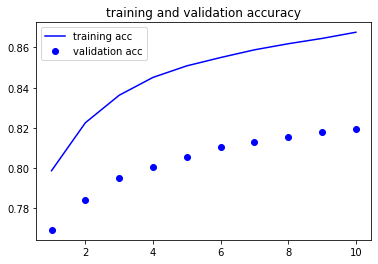

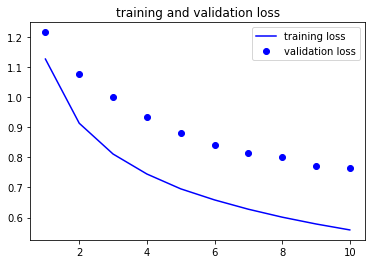

In [0]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
# 2. 단어를 빈도순으로 90%까지 포함하여 attention 모형 적용하여 기존 attention 모형과 비교하기

In [0]:
import numpy as np
import pandas as pd
import string

In [0]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])
# 구분다의 default는 \t임. sep='\t'

In [0]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [0]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [0]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [0]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [0]:
lines.shape

(50000, 2)

In [0]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.9]['word'].values

In [0]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.9]['word'].values

In [0]:
# 이 코드를 추가해줘야함. 그래야 깔끔함.
# final_fr_words = list(final_fr_words)
# final_fr_words = [ t.replace('\xa0',"") for t in final_fr_words]
# final_fr_words = [ t.replace('\u202f',"") for t in final_fr_words]
# final_fr_words=set(final_fr_words)
# final_fr_words = list(final_fr_words)
# final_fr_words=np.array(final_fr_words,dtype='object')

In [0]:
print(len(final_eng_words),len(final_fr_words))

961 1506


In [0]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
filter_eng_words('he is extremely good')

'he is unk good '

In [0]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
filter_fr_words('hi my fait')

'unk my fait '

In [0]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [0]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [0]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [0]:
len(all_eng_words)

962

In [0]:
len(target_words)

1488

In [0]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [0]:
num_decoder_tokens

1488

In [0]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[863])
print(list(target_token_index.keys())[1253])
print(list(target_token_index.keys())[421])

864
1254
422
unk
start
end


In [0]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [0]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [0]:
print(eng_max_length)
print(fr_max_length)

8
17


In [0]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [0]:
decoder_target_data.shape

(50000, 17, 1489)

In [0]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 422] = 1

In [0]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 1489)


In [0]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 422

In [0]:
print(len(final_fr_words))
print(len(all_french_words))

1506
1488


In [0]:
set(all_french_words)-set(final_fr_words)

{'unk'}

In [0]:
###### model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, concatenate
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
en_x = Dropout(0.1)(en_x) # overfiting이 있어 dropout 집어넣음.
encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(en_x) # 이제는 encoder_outputs를 사용함. attention을 위함.
encoder_states=[state_h, state_c]

decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1,128)(decoder_inputs)
decoder = Dropout(0.1)(dex)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=encoder_states) # ??? 아닌데??? (LSTM을 객체화 해야한다는 10-2에서 넘어옴) // 어쨋든 얘도 attention을 위해서 사용할꺼임.
print('encoder_outputs', encoder_outputs)
print('decoder', decoder)

encoder_outputs Tensor("lstm/Identity:0", shape=(None, 8, 256), dtype=float32)
decoder Tensor("lstm_1/Identity:0", shape=(None, 17, 256), dtype=float32)


In [0]:
t = Dense(5000, activation='tanh')(encoder_outputs)
t1 = Dense(5000, activation='tanh')(decoder) # -1~ 1 사이값을 지니도록 출력해서, 연산을 봄.
print(t)
print(t1)

Tensor("dense/Identity:0", shape=(None, 8, 5000), dtype=float32)
Tensor("dense_1/Identity:0", shape=(None, 17, 5000), dtype=float32)


In [0]:
from tensorflow.keras.layers import dot
attention = dot([t1, t], axes=[2, 2]) #이게 corr의 내적 각도를 보는중.
# axes는 1부터 출발하며, t1에 해당하는 축 2 (5000을 기준), t에 해당하는 축 2 (5000을 기준) 하여 inner product 연산 계산 -> 17x8이 튀어나옴. 당연히 축에 해당하는 size는 그 크기가 같아야함.
# 0은 의미상 batch 칸이지만, 쓸수는 없다. dot연산을 그렇게 정의해놓음.
attention

<tf.Tensor 'dot/Identity:0' shape=(None, 17, 8) dtype=float32>

In [0]:
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes = [2,1])
print('attention', attention)
print('encoder_outputs', encoder_outputs)
# 불어에 대한 hidden layer 값과, 영어에 대한 hidden layer의 값이 비슷하게 나옴.
print('context', context)

attention Tensor("activation/Identity:0", shape=(None, 17, 8), dtype=float32)
encoder_outputs Tensor("lstm/Identity:0", shape=(None, 8, 256), dtype=float32)
context Tensor("dot_1/Identity:0", shape=(None, 17, 256), dtype=float32)


In [0]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate/Identity:0", shape=(None, 17, 512), dtype=float32)


In [0]:
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = Dense( num_decoder_tokens+1, activation="softmax")(decoder_combined_context)
print('output', output)

output Tensor("dense_4/Identity:0", shape=(None, 17, 1489), dtype=float32)


In [0]:
model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [0]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 128)       123264      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      190592      input_2[0][0]                    
______________________________________________________________________________________________

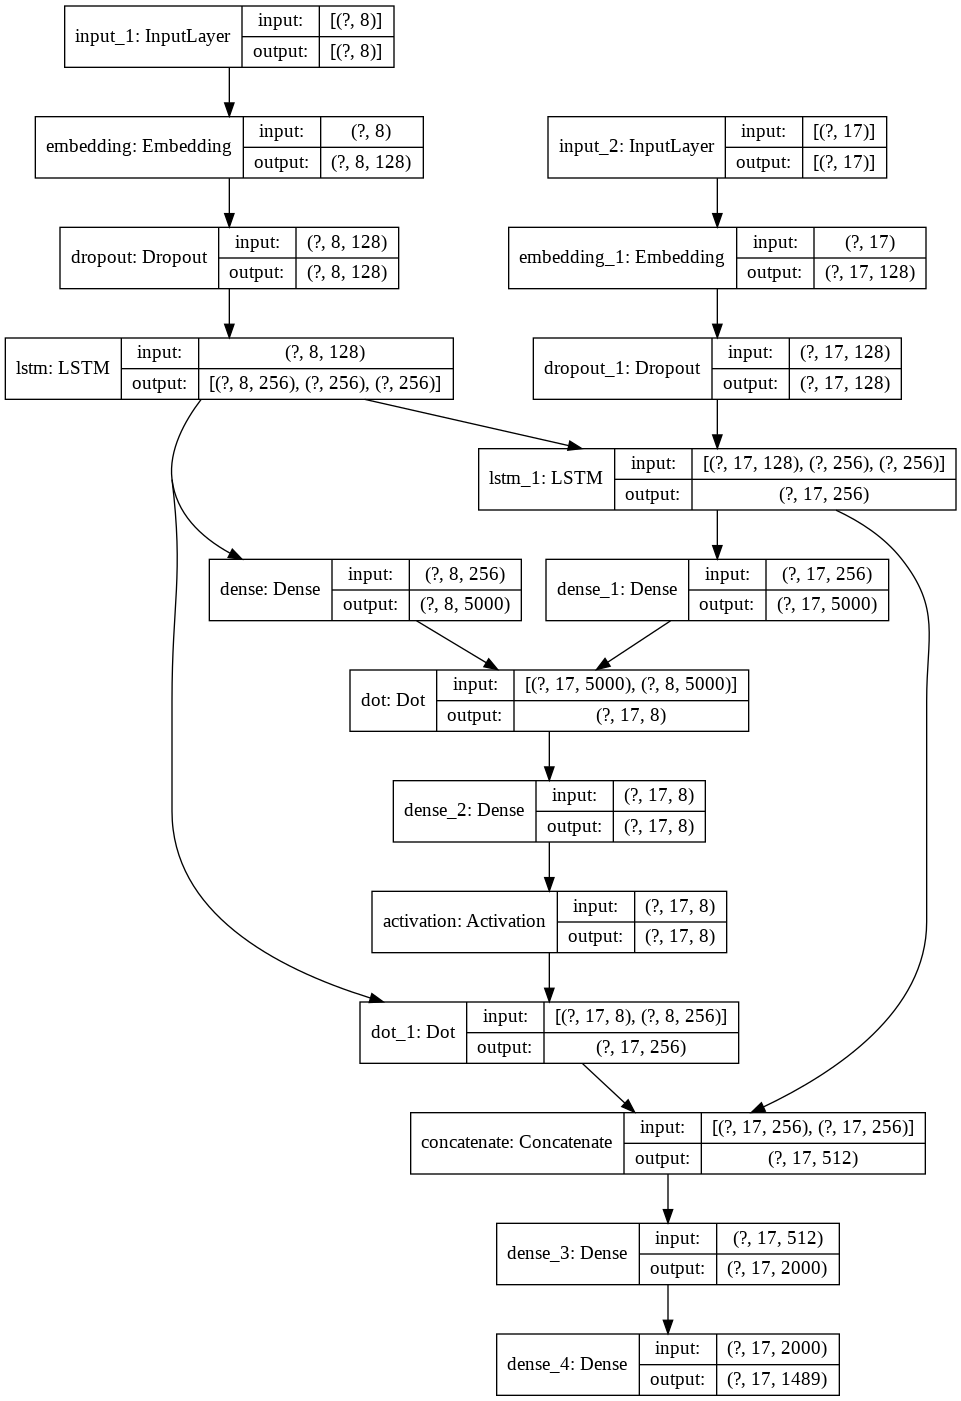

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=7,
          validation_split=0.05)

Epoch 1/7
1485/1485 [==============================] - 30s 20ms/step - loss: 1.0051 - accuracy: 0.8204 - val_loss: 0.9945 - val_accuracy: 0.7961
Epoch 2/7
1485/1485 [==============================] - 28s 19ms/step - loss: 0.5683 - accuracy: 0.8714 - val_loss: 0.7824 - val_accuracy: 0.8276
Epoch 3/7
1485/1485 [==============================] - 29s 19ms/step - loss: 0.4452 - accuracy: 0.8911 - val_loss: 0.6807 - val_accuracy: 0.8437
Epoch 4/7
1485/1485 [==============================] - 28s 19ms/step - loss: 0.3890 - accuracy: 0.9003 - val_loss: 0.6520 - val_accuracy: 0.8488
Epoch 5/7
1485/1485 [==============================] - 28s 19ms/step - loss: 0.3527 - accuracy: 0.9069 - val_loss: 0.6499 - val_accuracy: 0.8504
Epoch 6/7
1485/1485 [==============================] - 28s 19ms/step - loss: 0.3234 - accuracy: 0.9124 - val_loss: 0.6367 - val_accuracy: 0.8553
Epoch 7/7
1485/1485 [==============================] - 28s 19ms/step - loss: 0.3022 - accuracy: 0.9164 - val_loss: 0.6298 - val_ac

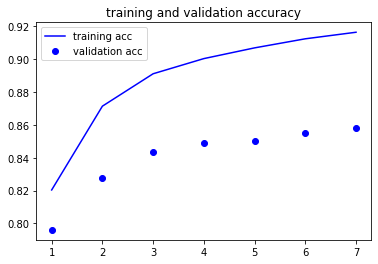

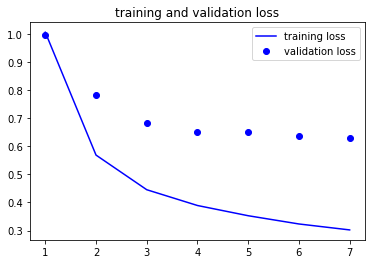

In [0]:
import matplotlib.pyplot as plt
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  word = 1254
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==422:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))

In [0]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=422))
  count += np.sum(decoder_input_data[47500+i]!=422)
correct_count/count  

0.5013813889237725

In [0]:
k = -2400

In [0]:
t = model3.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [0]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
feel
like
unk


In [0]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

jai
envie
de
unk
du
unk
end
end
end
end
end
end
end
end
end
end
end


In [0]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
jai
envie
de
faire
la
fête
end
end
end
end
end
end
end
end
end
end


In [0]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])
# 구분다의 default는 \t임. sep='\t'

In [0]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [0]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [0]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [0]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [0]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [0]:
lines.shape

(50000, 2)

In [0]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

Using TensorFlow backend.


In [0]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [0]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
filter_eng_words('he is extremely good')

'he is unk good '

In [0]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [0]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [0]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [0]:
len(all_eng_words)

385

In [0]:
len(target_words)

358

In [0]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [0]:
num_decoder_tokens

358

In [0]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [0]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [0]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [0]:
print(eng_max_length)
print(fr_max_length)

8
17


In [0]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [0]:
decoder_target_data.shape

(50000, 17, 359)

In [0]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [0]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [0]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [0]:
# 이 위에서는 전부 똑같다.

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, concatenate
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
en_x = Dropout(0.1)(en_x) # overfiting이 있어 dropout 집어넣음.
encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(en_x) # 이제는 encoder_outputs를 사용함. attention을 위함.
encoder_states=[state_h, state_c]

decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1,128)(decoder_inputs)
decoder = Dropout(0.1)(dex)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=encoder_states) # ??? 아닌데??? (LSTM을 객체화 해야한다는 10-2에서 넘어옴) // 어쨋든 얘도 attention을 위해서 사용할꺼임.
print('encoder_outputs', encoder_outputs)
print('decoder', decoder)

encoder_outputs Tensor("lstm/Identity:0", shape=(None, 8, 256), dtype=float32)
decoder Tensor("lstm_1/Identity:0", shape=(None, 17, 256), dtype=float32)


In [0]:
t = Dense(5000, activation='tanh')(encoder_outputs)
t1 = Dense(5000, activation='tanh')(decoder) # -1~ 1 사이값을 지니도록 출력해서, 연산을 봄.
print(t)
print(t1)

Tensor("dense/Identity:0", shape=(None, 8, 5000), dtype=float32)
Tensor("dense_1/Identity:0", shape=(None, 17, 5000), dtype=float32)


In [0]:
from tensorflow.keras.layers import dot
attention = dot([t1, t], axes=[2, 2]) #이게 corr의 내적 각도를 보는중.
# axes는 1부터 출발하며, t1에 해당하는 축 2 (5000을 기준), t에 해당하는 축 2 (5000을 기준) 하여 inner product 연산 계산 -> 17x8이 튀어나옴. 당연히 축에 해당하는 size는 그 크기가 같아야함.
# 0은 의미상 batch 칸이지만, 쓸수는 없다. dot연산을 그렇게 정의해놓음.
attention

<tf.Tensor 'dot/Identity:0' shape=(None, 17, 8) dtype=float32>

In [0]:
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes = [2,1])
print('attention', attention)
print('encoder_outputs', encoder_outputs)
# 불어에 대한 hidden layer 값과, 영어에 대한 hidden layer의 값이 비슷하게 나옴.
print('context', context)

attention Tensor("activation/Identity:0", shape=(None, 17, 8), dtype=float32)
encoder_outputs Tensor("lstm/Identity:0", shape=(None, 8, 256), dtype=float32)
context Tensor("dot_1/Identity:0", shape=(None, 17, 256), dtype=float32)


In [0]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate/Identity:0", shape=(None, 17, 512), dtype=float32)


In [0]:
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = Dense( num_decoder_tokens+1, activation="softmax")(decoder_combined_context)
print('output', output)

output Tensor("dense_4/Identity:0", shape=(None, 17, 359), dtype=float32)


In [0]:
model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [0]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 128)       49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      45952       input_2[0][0]                    
______________________________________________________________________________________________

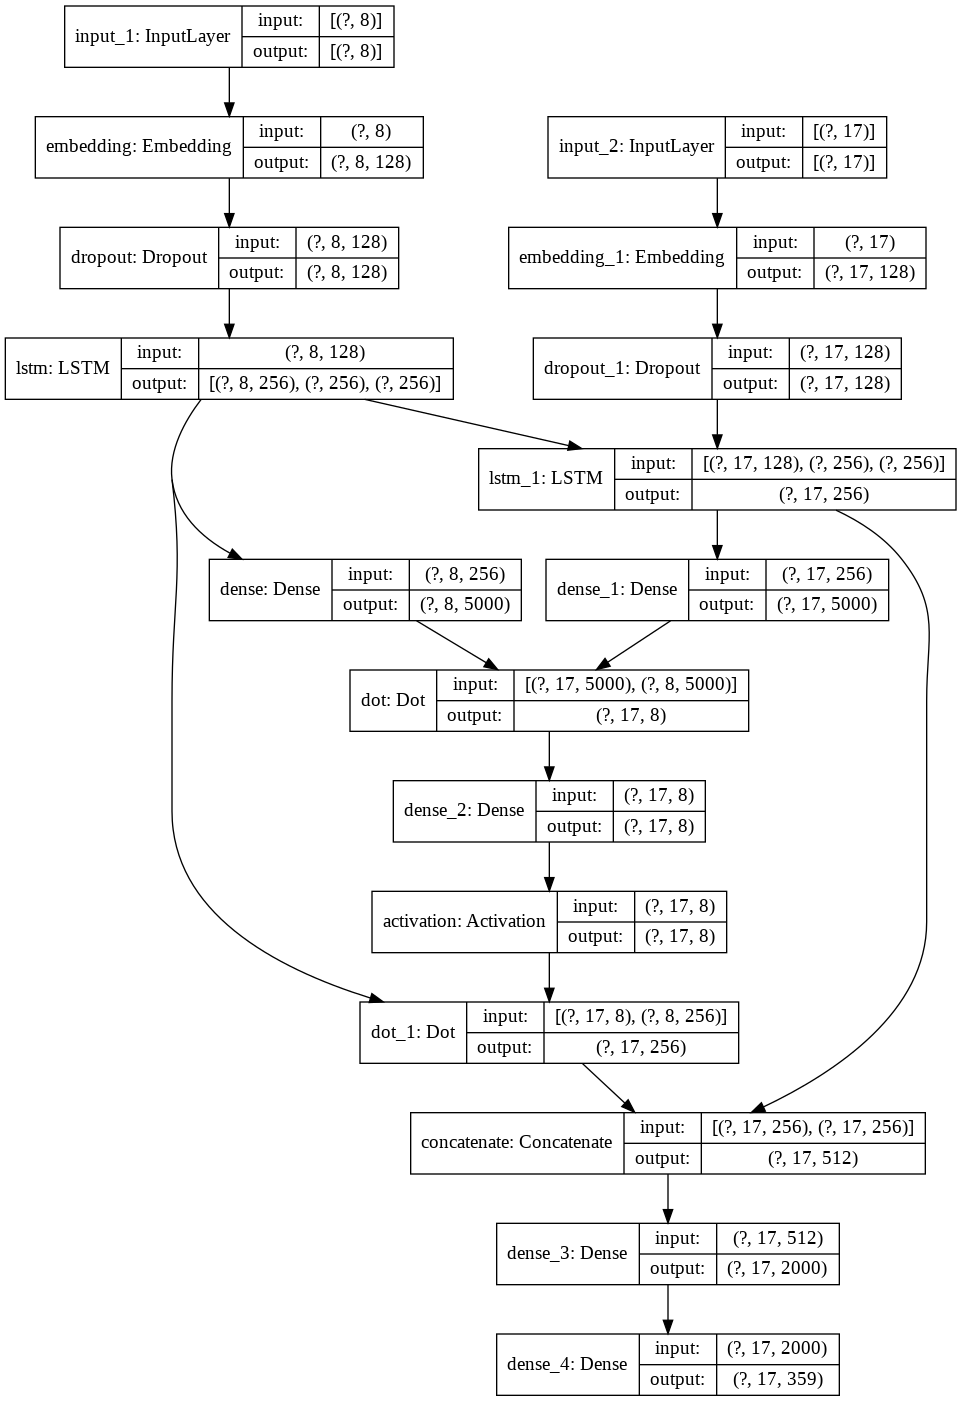

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=7,
          validation_split=0.05)

Epoch 1/7
1485/1485 [==============================] - 45s 30ms/step - loss: 0.7261 - accuracy: 0.8504 - val_loss: 0.7025 - val_accuracy: 0.8306
Epoch 2/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.4360 - accuracy: 0.8901 - val_loss: 0.5883 - val_accuracy: 0.8528
Epoch 3/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.3742 - accuracy: 0.9009 - val_loss: 0.5502 - val_accuracy: 0.8611
Epoch 4/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.3397 - accuracy: 0.9076 - val_loss: 0.5222 - val_accuracy: 0.8647
Epoch 5/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.3172 - accuracy: 0.9119 - val_loss: 0.5032 - val_accuracy: 0.8695
Epoch 6/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.2955 - accuracy: 0.9162 - val_loss: 0.5003 - val_accuracy: 0.8717
Epoch 7/7
1485/1485 [==============================] - 44s 30ms/step - loss: 0.2811 - accuracy: 0.9191 - val_loss: 0.5031 - val_ac

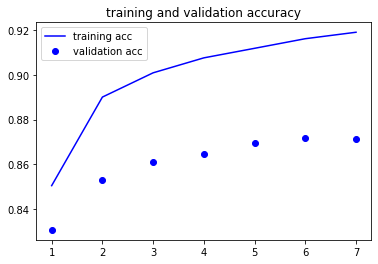

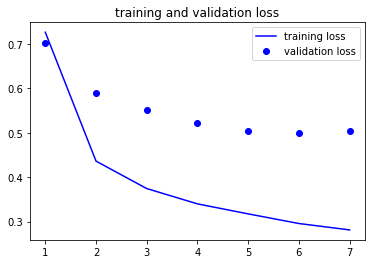

In [0]:
import matplotlib.pyplot as plt
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))

In [0]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count  

0.5199045585834484

In [0]:
k = -2400

In [0]:
t = model3.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [0]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
feel
like
unk


In [0]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

je
unk
unk
unk
du
unk
end
end
end
end
end
end
end
end
end
end
end


In [0]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
jai
unk
de
faire
la
unk
end
end
end
end
end
end
end
end
end
end
